# Text Analysis with NLTK

Author: Jesús Cid-Sueiro

Date: 2016/04/03

Last review: 2016/11/16

In [1]:
%matplotlib inline

# Required imports
from wikitools import wiki
from wikitools import category

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np

from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt
import pylab

from test_helper import Test

import gensim

## 1. Corpus acquisition.
In this notebook we will explore some tools for text analysis available from Python toolboxes.

To do so, we will explore and analyze collections of Wikipedia articles from a given category, using `wikitools`, that makes the capture of content from wikimedia sites very easy.

(*As a side note, there are many other available text collections to work with. In particular, the NLTK library has many examples, that you can explore using the `nltk.download()` tool*.

    import nltk
    nltk.download()

*for instance, you can take the gutemberg dataset*

    Mycorpus = nltk.corpus.gutenberg
    text_name = Mycorpus.fileids()[0]
    raw = Mycorpus.raw(text_name)
    Words = Mycorpus.words(text_name)

*Also, tools like Gensim or Sci-kit learn include text databases to work with*).

In order to use Wikipedia data, we will select a single category of articles:

In [2]:
site = wiki.Wiki("https://en.wikipedia.org/w/api.php")
# Select a category with a reasonable number of articles (>100)
# cat = "Economics"
cat = "Pseudoscience"
print cat

Pseudoscience


You can try with any other categories, but take into account that some categories may contain very few articles. Select a category with at least 100 articles. You can browse the wikipedia category tree here, https://en.wikipedia.org/wiki/Category:Contents, for instance, and select the appropriate one.

We start downloading the text collection.

In [3]:
# Loading category data. This may take a while
print "Loading category data. This may take a while..."
cat_data = category.Category(site, cat)

corpus_titles = []
corpus_text = []

for n, page in enumerate(cat_data.getAllMembersGen()):
    print "\r Loading article {0}".format(n + 1),
    corpus_titles.append(page.title)
    corpus_text.append(page.getWikiText())

n_art = len(corpus_titles)
print "\nLoaded " + str(n_art) + " articles from category " + cat

Loading category data. This may take a while...
 Loading article 359 
Loaded 359 articles from category Pseudoscience


Now, we have stored the whole text collection in two lists:

* `corpus_titles`, which contains the titles of the selected articles
* `corpus_text`, with the text content of the selected wikipedia articles

You can browse the content of the wikipedia articles to get some intuition about the kind of documents that will be processed.

In [4]:
n = 5
print corpus_titles[n]
print corpus_text[n+1]

Alternative medicine
{{Infobox company
| name = Amen Clinics
| logo = Amen Clinics Logo.png
| type = 
| industry = 
| founded =             {{start date|1989}}
| founder =             [[Daniel Amen|Daniel G. Amen]]
| hq_location = 
| hq_location_city = 
| hq_location_country = [[United States]]
| area_served =       [[Newport Beach, California]], [[San Francisco|San Francisco, California]], [[Atlanta|Atlanta, Georgia]], [[Reston, Virginia]], [[Bellevue, Washington]], [[New York City]]
| key_people = 
| products = 
| brands = 
| services = 
| owner =               <!-- or: | owners = -->
| website =             {{URL|http://www.amenclinics.com/}}
}}

'''Amen Clinics''' is a group of mental and physical health clinics that work on the treatment of mood and behavior disorders. It was founded in 1989 by [[Daniel Amen|Daniel G. Amen]], MD. a self-help guru and [[psychiatrist]].<ref name=mad>{{cite journal|doi=10.1016/S1474-4422(08)70056-5|title=Neuropolitics gone mad|year=2008|author=James 

## 2. Corpus Processing

Topic modelling algorithms process vectorized data. In order to apply them, we need to transform the raw text input data into a vector representation. To do so, we will remove irrelevant information from the text data and preserve as much relevant information as possible to capture the semantic content in the document collection.

Thus, we will proceed with the following steps:

1. Tokenization
2. Homogeneization
3. Cleaning
4. Vectorization

### 2.1. Tokenization

For the first steps, we will use some of the powerfull methods available from the [Natural Language Toolkit](http://www.nltk.org). In order to use the `word_tokenize` method from nltk, you might need to get the appropriate libraries using `nltk.download()`. You must select option "d) Download", and identifier "punkt"

In [5]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "punkt"
# nltk.download()

**Task**: Insert the appropriate call to `word_tokenize` in the code below, in order to get the tokens list corresponding to each Wikipedia article:

In [6]:
corpus_tokens = []

for n, art in enumerate(corpus_text): 
    print "\rTokenizing article {0} out of {1}".format(n + 1, n_art),
    # This is to make sure that all characters have the appropriate encoding.
    art = art.decode('utf-8')  
    
    # Tokenize each text entry. 
    # scode: tokens = <FILL IN>
    tokens = word_tokenize(art)
    
    # Add the new token list as a new element to corpus_tokens (that will be a list of lists)
    # scode: <FILL IN>
    corpus_tokens.append(tokens)

print "\n The corpus has been tokenized. Let's check some portion of the first article:"
print corpus_tokens[0][0:30]

Tokenizing article 359 out of 359 
 The corpus has been tokenized. Let's check some portion of the first article:
[u'{', u'{', u'see', u'also|List', u'of', u'topics', u'characterized', u'as', u'pseudoscience', u'}', u'}', u'{', u'{', u'broader|Pseudo-scholarship', u'}', u'}', u'{', u'{', u'Science|phil/hist', u'}', u'}', u"'", u"''", u'Pseudoscience', u"''", u"'", u'consists', u'of', u'claims', u',']


In [7]:
Test.assertEquals(len(corpus_tokens), n_art, "The number of articles has changed unexpectedly")
Test.assertTrue(len(corpus_tokens) >= 100, 
                "Your corpus_tokens has less than 100 articles. Consider using a larger dataset")

1 test passed.
1 test passed.


### 2.2. Homogeneization

By looking at the tokenized corpus you may verify that there are many tokens that correspond to punktuation signs and other symbols that are not relevant to analyze the semantic content. They can be removed using the stemming tool from `nltk`.

The homogeneization process will consist of:

1. Removing capitalization: capital alphabetic characters will be transformed to their corresponding lowercase characters.
2. Removing non alphanumeric tokens (e.g. punktuation signs)
3. Stemming/Lemmatization: removing word terminations to preserve the root of the words and ignore grammatical information.

#### 2.2.1. Filtering

Let us proceed with the filtering steps 1 and 2 (removing capitalization and non-alphanumeric tokens).

**Task**: Convert all tokens in `corpus_tokens` to lowercase (using `.lower()` method) and remove non alphanumeric tokens (that you can detect with `.isalnum()` method). You can do it in a single line of code...

In [8]:
corpus_filtered = []

for n, token_list in enumerate(corpus_tokens):
    print "\rFiltering article {0} out of {1}".format(n + 1, n_art),
    
    # Convert all tokens in token_list to lowercase, remove non alfanumeric tokens and stem.
    # Store the result in a new token list, clean_tokens.
    # scode: filtered_tokens = <FILL IN>
    filtered_tokens = [token.lower() for token in token_list if token.isalnum()]
    
    # Add art to corpus_filtered
    # scode: <FILL IN>
    corpus_filtered.append(filtered_tokens)

print "\nLet's check the first tokens from document 0 after filtering:"
print corpus_filtered[0][0:30]

Filtering article 359 out of 359 
Let's check the first tokens from document 0 after filtering:
[u'see', u'of', u'topics', u'characterized', u'as', u'pseudoscience', u'pseudoscience', u'consists', u'of', u'claims', u'belief', u's', u'or', u'practices', u'presented', u'as', u'being', u'plausible', u'scientifically', u'but', u'which', u'are', u'not', u'justifiable', u'by', u'the', u'scientific', u'method', u'tag', u'a']


In [9]:
Test.assertTrue(all([c==c.lower() for c in corpus_filtered[23]]), 'Capital letters have not been removed')
Test.assertTrue(all([c.isalnum() for c in corpus_filtered[13]]), 'Non alphanumeric characters have not been removed')

1 test passed.
1 test passed.


#### 2.2.2. Stemming vs Lemmatization

At this point, we can choose between applying a simple stemming or ussing lemmatization. We will try both to test their differences.

**Task**: Apply the `.stem()` method, from the stemmer object created in the first line, to `corpus_filtered`.

In [10]:
# Select stemmer.
stemmer = nltk.stem.SnowballStemmer('english')
corpus_stemmed = []

for n, token_list in enumerate(corpus_filtered):
    print "\rStemming article {0} out of {1}".format(n + 1, n_art),
    
    # Convert all tokens in token_list to lowercase, remove non alfanumeric tokens and stem.
    # Store the result in a new token list, clean_tokens.
    # scode: stemmed_tokens = <FILL IN>
    stemmed_tokens = [stemmer.stem(token) for token in token_list]
    
    # Add art to the stemmed corpus
    # scode: <FILL IN>
    corpus_stemmed.append(stemmed_tokens)

print "\nLet's check the first tokens from document 0 after stemming:"
print corpus_stemmed[0][0:30]

Stemming article 359 out of 359 
Let's check the first tokens from document 0 after stemming:
[u'see', u'of', u'topic', u'character', u'as', u'pseudosci', u'pseudosci', u'consist', u'of', u'claim', u'belief', u's', u'or', u'practic', u'present', u'as', u'be', u'plausibl', u'scientif', u'but', u'which', u'are', u'not', u'justifi', u'by', u'the', u'scientif', u'method', u'tag', u'a']


In [11]:
Test.assertTrue((len([c for c in corpus_stemmed[0] if c!=stemmer.stem(c)]) < 0.1*len(corpus_stemmed[0])), 
                'It seems that stemming has not been applied properly')

1 test passed.


Alternatively, we can apply lemmatization. For english texts, we can use the lemmatizer from NLTK, which is based on [WordNet](http://wordnet.princeton.edu). If you have not used wordnet before, you will likely need to download it from nltk

In [12]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "wordnet"
# nltk.download()

**Task**: Apply the `.lemmatize()` method, from the WordNetLemmatizer object created in the first line, to `corpus_filtered`.

In [13]:
wnl = WordNetLemmatizer()

# Select stemmer.
corpus_lemmat = []

for n, token_list in enumerate(corpus_filtered):
    print "\rLemmatizing article {0} out of {1}".format(n + 1, n_art),
    
    # scode: lemmat_tokens = <FILL IN>
    lemmat_tokens = [wnl.lemmatize(token) for token in token_list]

    # Add art to the stemmed corpus
    # scode: <FILL IN>
    corpus_lemmat.append(lemmat_tokens)

print "\nLet's check the first tokens from document 0 after lemmatization:"
print corpus_lemmat[0][0:30]

Lemmatizing article 359 out of 359 
Let's check the first tokens from document 0 after lemmatization:
[u'see', u'of', u'topic', u'characterized', u'a', u'pseudoscience', u'pseudoscience', u'consists', u'of', u'claim', u'belief', u's', u'or', u'practice', u'presented', u'a', u'being', u'plausible', u'scientifically', u'but', u'which', u'are', u'not', u'justifiable', u'by', u'the', u'scientific', u'method', u'tag', u'a']


One of the advantages of the lemmatizer method is that the result of lemmmatization is still a true word, which is more advisable for the presentation of text processing results and lemmatization.

However, without using contextual information, lemmatize() does not remove grammatical differences. This is the reason why "is" or "are" are preserved and not replaced by infinitive "be".

As an alternative, we can apply .lemmatize(word, pos), where 'pos' is a string code specifying the part-of-speech (pos), i.e. the grammatical role of the words in its sentence. For instance, you can check the difference between `wnl.lemmatize('is')` and `wnl.lemmatize('is, pos='v')`.

### 2.3. Cleaning

The third step consists of removing those words that are very common in language and do not carry out usefull semantic content (articles, pronouns, etc).

Once again, we might need to load the stopword files using the download tools from `nltk`

In [14]:
# You can comment this if the package is already available.
# Select option "d) Download", and identifier "stopwords"
# nltk.download()

** Task**: In the second line below we read a list of common english stopwords. Clean `corpus_stemmed` by removing all tokens in the stopword list.

In [15]:
corpus_clean = []
stopwords_en = stopwords.words('english')
n = 0
for token_list in corpus_stemmed:
    n += 1
    print "\rRemoving stopwords from article {0} out of {1}".format(n, n_art),

    # Remove all tokens in the stopwords list and append the result to corpus_clean
    # scode: clean_tokens = <FILL IN>
    clean_tokens = [token for token in token_list if token not in stopwords_en]    

    # scode: <FILL IN>
    corpus_clean.append(clean_tokens)
    
print "\n Let's check tokens after cleaning:"
print corpus_clean[0][0:30]

Removing stopwords from article 359 out of 359 
 Let's check tokens after cleaning:
[u'see', u'topic', u'character', u'pseudosci', u'pseudosci', u'consist', u'claim', u'belief', u'practic', u'present', u'plausibl', u'scientif', u'justifi', u'scientif', u'method', u'tag', u'pretend', u'spurious', u'scienc', u'collect', u'relat', u'belief', u'world', u'mistaken', u'regard', u'base', u'scientif', u'method', u'status', u'scientif']


In [16]:
Test.assertTrue(len(corpus_clean) == n_art, 'List corpus_clean does not contain the expected number of articles')
Test.assertTrue(len([c for c in corpus_clean[0] if c in stopwords_en])==0, 'Stopwords have not been removed')

1 test passed.
1 test passed.


### 2.4. Vectorization

Up to this point, we have transformed the raw text collection of articles in a list of articles, where each article is a collection of the word roots that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.

In [17]:
# Create dictionary of tokens
D = gensim.corpora.Dictionary(corpus_clean)
n_tokens = len(D)

print "The dictionary contains {0} tokens".format(n_tokens)
print "First tokens in the dictionary: "
for n in range(10):
    print str(n) + ": " + D[n]

The dictionary contains 33632 tokens
First tokens in the dictionary: 
0: divers
1: demand
2: four
3: edward
4: testabl
5: 20good
6: everi
7: risk
8: voic
9: distort


In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, `D.doc2bow(token_list)` transform any list of tokens into a list of tuples `(token_id, n)`, one per each token in `token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences of such token in `token_list`. 

** Task**: Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every article in `corpus_clean`. The result must be a new list named `corpus_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [18]:
# Transform token lists into sparse vectors on the D-space
# scode: corpus_bow = <FILL IN>
corpus_bow = [D.doc2bow(doc) for doc in corpus_clean]

In [19]:
Test.assertTrue(len(corpus_bow)==n_art, 'corpus_bow has not the appropriate size') 

1 test passed.


At this point, it is good to make sure to understand what has happened. In `corpus_clean` we had a list of token lists. With it, we have constructed a Dictionary, `D`, which assign an integer identifier to each token in the corpus.
After that, we have transformed each article (in `corpus_clean`) in a list tuples `(id, n)`. 

In [20]:
print "Original article (after cleaning): "
print corpus_clean[0][0:30]
print "Sparse vector representation (first 30 components):"
print corpus_bow[0][0:30]
print "The first component, {0} from document 0, states that token 0 ({1}) appears {2} times".format(
    corpus_bow[0][0], D[0], corpus_bow[0][0][1])

Original article (after cleaning): 
[u'see', u'topic', u'character', u'pseudosci', u'pseudosci', u'consist', u'claim', u'belief', u'practic', u'present', u'plausibl', u'scientif', u'justifi', u'scientif', u'method', u'tag', u'pretend', u'spurious', u'scienc', u'collect', u'relat', u'belief', u'world', u'mistaken', u'regard', u'base', u'scientif', u'method', u'status', u'scientif']
Sparse vector representation (first 30 components):
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 3), (10, 1), (11, 3), (12, 1), (13, 1), (14, 2), (15, 1), (16, 4), (17, 1), (18, 147), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 5), (27, 19), (28, 2), (29, 1)]
The first component, (0, 1) from document 0, states that token 0 (divers) appears 1 times


Note that we can interpret each element of corpus_bow as a `sparse_vector`. For example, a list of tuples 

    [(0, 1), (3, 3), (5,2)] 

for a dictionary of 10 elements can be represented as a vector, where any tuple `(id, n)` states that position `id` must take value `n`. The rest of positions must be zero.

    [1, 0, 0, 3, 0, 2, 0, 0, 0, 0]

These sparse vectors will be the inputs to the topic modeling algorithms.

Note that, at this point, we have built a Dictionary containing

In [21]:
print "{0} tokens".format(len(D))

33632 tokens


and a bow representation of a corpus with

In [22]:
print "{0} Wikipedia articles".format(len(corpus_bow))

359 Wikipedia articles


Before starting with the semantic analyisis, it is interesting to observe the token distribution for the given corpus.

In [23]:
# SORTED TOKEN FREQUENCIES (I):
# Create a "flat" corpus with all tuples in a single list
corpus_bow_flat = [item for sublist in corpus_bow for item in sublist]

# Initialize a numpy array that we will use to count tokens.
# token_count[n] should store the number of ocurrences of the n-th token, D[n]
token_count = np.zeros(n_tokens)

# Count the number of occurrences of each token.
for x in corpus_bow_flat:
    # Update the proper element in token_count
    # scode: <FILL IN>
    token_count[x[0]] += x[1]

# Sort by decreasing number of occurences
ids_sorted = np.argsort(- token_count)
tf_sorted = token_count[ids_sorted]

`ids_sorted` is a list of all token ids, sorted by decreasing number of occurrences in the whole corpus. For instance, the most frequent term is 

In [24]:
print D[ids_sorted[0]]

ref


which appears

In [25]:
print "{0} times in the whole corpus".format(tf_sorted[0])

16713.0 times in the whole corpus


In the following we plot the most frequent terms in the corpus.

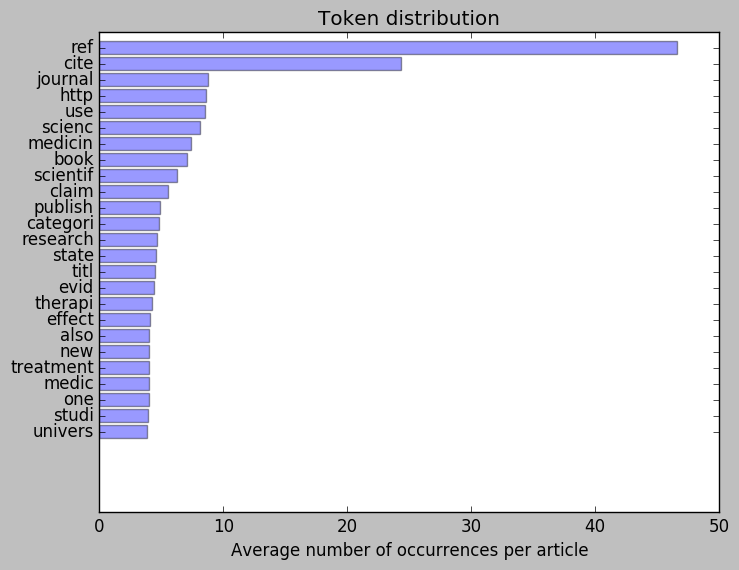

In [26]:
# SORTED TOKEN FREQUENCIES (II):
plt.rcdefaults()

# Example data
n_bins = 25
hot_tokens = [D[i] for i in ids_sorted[n_bins-1::-1]]
y_pos = np.arange(len(hot_tokens))
z = tf_sorted[n_bins-1::-1]/n_art

plt.barh(y_pos, z, align='center', alpha=0.4)
plt.yticks(y_pos, hot_tokens)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

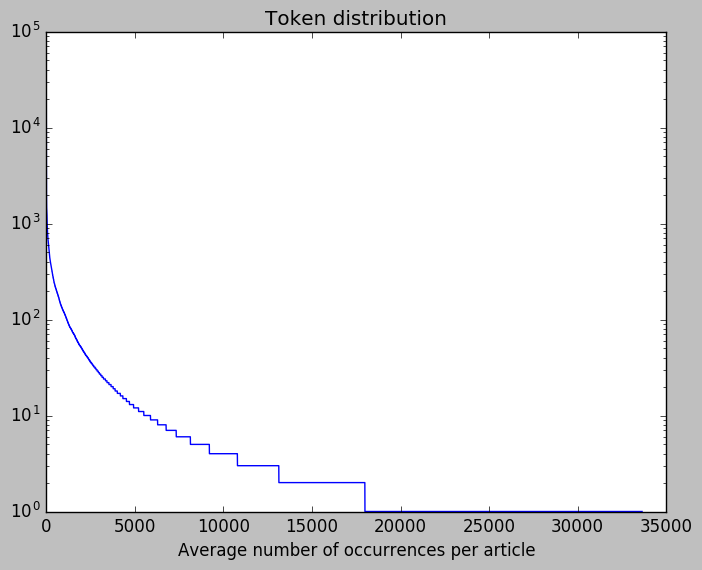

In [27]:
# SORTED TOKEN FREQUENCIES:

# Example data
plt.semilogy(tf_sorted)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

** Exercise**: There are usually many tokens that appear with very low frequency in the corpus. Count the number of tokens appearing only once, and what is the proportion of them in the token list.

In [29]:
# scode: <WRITE YOUR CODE HERE>
# Example data
cold_tokens = [D[i] for i in ids_sorted if tf_sorted[i]==1]

print "There are {0} cold tokens, which represent {1}% of the total number of tokens in the dictionary".format(
    len(cold_tokens), float(len(cold_tokens))/n_tokens*100)

There are 15650 cold tokens, which represent 46.5330637488% of the total number of tokens in the dictionary


** Exercise**: Represent graphically those 20 tokens that appear in the highest number of articles. Note that you can use the code above (headed by `# SORTED TOKEN FREQUENCIES`) with a very minor modification.

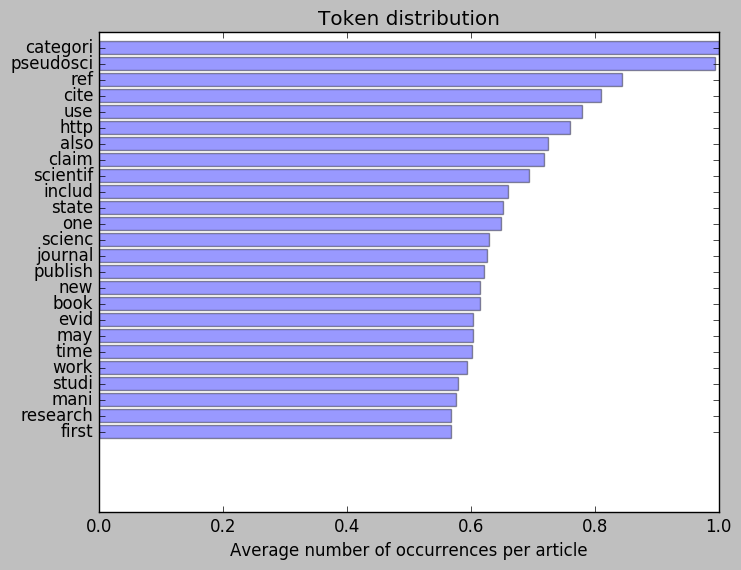

In [30]:
# scode: <WRITE YOUR CODE HERE>

# SORTED TOKEN FREQUENCIES (I):
# Count the number of occurrences of each token.
token_count2 = np.zeros(n_tokens)
for x in corpus_bow_flat:
    token_count2[x[0]] += (x[1]>0)

# Sort by decreasing number of occurences
ids_sorted2 = np.argsort(- token_count2)
tf_sorted2 = token_count2[ids_sorted2]

# SORTED TOKEN FREQUENCIES (II):
# Example data
n_bins = 25
hot_tokens2 = [D[i] for i in ids_sorted2[n_bins-1::-1]]
y_pos2 = np.arange(len(hot_tokens2))
z2 = tf_sorted2[n_bins-1::-1]/n_art

plt.barh(y_pos2, z2, align='center', alpha=0.4)
plt.yticks(y_pos2, hot_tokens2)
plt.xlabel('Average number of occurrences per article')
plt.title('Token distribution')
plt.show()

** Exercise**: Count the number of tokens appearing only in a single article.


In [ ]:
# scode: <WRITE YOUR CODE HERE>

** Exercise** (*All in one*): Note that, for pedagogical reasons, we have used a different `for` loop for each text processing step creating a new `corpus_xxx` variable after each step. For very large corpus, this could cause memory problems. 

As a summary exercise, repeat the whole text processing, starting from corpus_text up to computing the bow, with the following modifications:

1. Use a single `for` loop, avoiding the creation of any intermediate corpus variables.
2. Use lemmatization instead of stemming.
3. Remove all tokens appearing in only one document and less than 2 times.
4. Save the result in a new variable `corpus_bow1`.

In [ ]:
# scode: <WRITE YOUR CODE HERE>

** Exercise** (*Visualizing categories*): Repeat the previous exercise with a second wikipedia category. For instance, you can take "communication". 

1. Save the result in variable `corpus_bow2`.
2. Determine the most frequent terms in `corpus_bow1` (`term1`) and `corpus_bow2` (`term2`).
3. Transform each article in `corpus_bow1` and `corpus_bow2` into a 2 dimensional vector, where the first component is the frecuency of `term1` and the second component is the frequency of `term2`
4. Draw a dispersion plot of all 2 dimensional points, using a different marker for each corpus. Could you differentiate both corpora using the selected terms only? What if the 2nd most frequent term is used?
    

In [ ]:
# scode: <WRITE YOUR CODE HERE>

** Exercise ** (bigrams): `nltk` provides an utility to compute n-grams from a list of tokens, in `nltk.util.ngrams`. Join all tokens in `corpus_clean` in a single list and compute the bigrams. Plot the 20 most frequent bigrams in the corpus.

In [ ]:
# scode: <WRITE YOUR CODE HERE>
# Check the code below to see how ngrams works, and adapt it to solve the exercise.
# from nltk.util import ngrams
# sentence = 'this is a foo bar sentences and i want to ngramize it'
# sixgrams = ngrams(sentence.split(), 2)
# for grams in sixgrams:
#     print grams